# QAE

In [2]:
# Essential libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.result import marginal_distribution
from qiskit.transpiler import generate_preset_pass_manager
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
import pandas as pd
import math
import time

from collections import Counter

# step 1

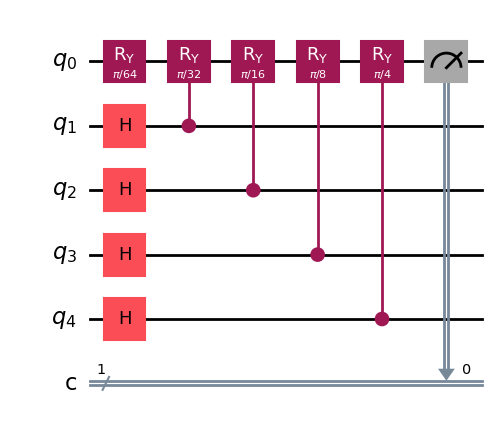

In [3]:
# build circuit
qr = QuantumRegister(5, name='q')
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr, cr)

qc.h(range(1, 5))

# set angles
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i, 0)
# measure
qc.measure(0, 0)

# show
qc.draw('mpl')


# step 2--build function

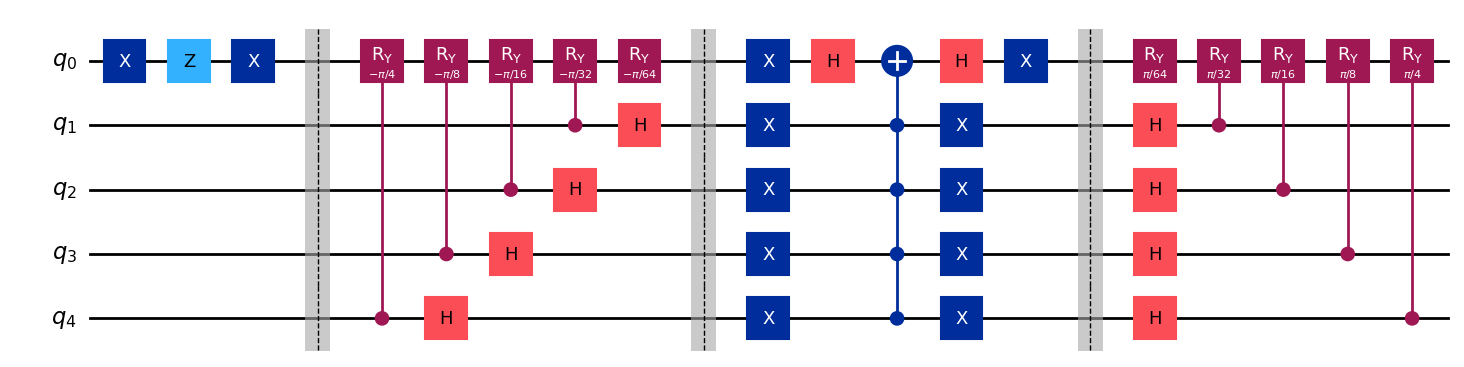

In [4]:
# build circuit
qr = QuantumRegister(5, name='q')
qc = QuantumCircuit(qr)

# S_phi_0
qc.x(0)
qc.z(0)
qc.x(0)
# barrier
qc.barrier()

# A^dagger
qc.cry(-np.pi/4, 4,0)
qc.cry(-np.pi/8, 3,0)
qc.cry(-np.pi/16, 2,0)
qc.cry(-np.pi/32, 1,0)
qc.ry(-np.pi/64, 0)
qc.h(range(1, 5))
# barrier
qc.barrier()

# S_0
qc.x(range(5))
qc.h(0)
qc.mcx([1, 2, 3, 4], 0)
qc.h(0)
qc.x(range(5))

# qc.h(range(1,5))
# qc.x(0)
# qc.h(0)
# qc.x(range(1,5))
# qc.mcx([1, 2, 3, 4], 0)
# qc.h(0)
# qc.x(range(5))
# qc.h(range(1,5))
# qc.barrier()

# barrier
qc.barrier()

# A
qc.h(range(1, 5))
qc.ry(np.pi/64, 0)
qc.cry(np.pi/32, 1,0)
qc.cry(np.pi/16, 2,0)
qc.cry(np.pi/8, 3,0)
qc.cry(np.pi/4, 4,0)

# show
qc.draw('mpl')

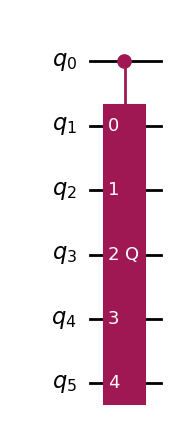

In [5]:
# set to funtion
def custom_block_gate():
    block_qc = QuantumCircuit(5, name="Q")

    # S_phi_0
    block_qc.x(0)
    block_qc.z(0)
    block_qc.x(0)

    # A^dagger
    block_qc.cry(-np.pi/4, 4, 0)
    block_qc.cry(-np.pi/8, 3, 0)
    block_qc.cry(-np.pi/16, 2, 0)
    block_qc.cry(-np.pi/32, 1, 0)
    block_qc.ry(-np.pi/64, 0)
    block_qc.h(range(1, 5))

    # S_0
    block_qc.x(range(5))
    block_qc.h(0)
    block_qc.mcx([1, 2, 3, 4], 0)
    block_qc.h(0)
    block_qc.x(range(5))

    # A
    block_qc.h(range(1, 5))
    block_qc.ry(np.pi/64, 0)
    block_qc.cry(np.pi/32, 1, 0)
    block_qc.cry(np.pi/16, 2, 0)
    block_qc.cry(np.pi/8, 3, 0)
    block_qc.cry(np.pi/4, 4, 0)

    # change to gate
    return block_qc.to_gate()

# example
qc = QuantumCircuit(6)
block_gate = custom_block_gate()
controlled_block = block_gate.control(1)
qc.append(controlled_block, [0, 1, 2, 3, 4, 5])

# show
qc.draw('mpl')


# QAE algorithm

## 3 qubit

C:\Users\ACER\AppData\Local\Temp\ipykernel_22848\3645743939.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=3, do_swaps=True).inverse()


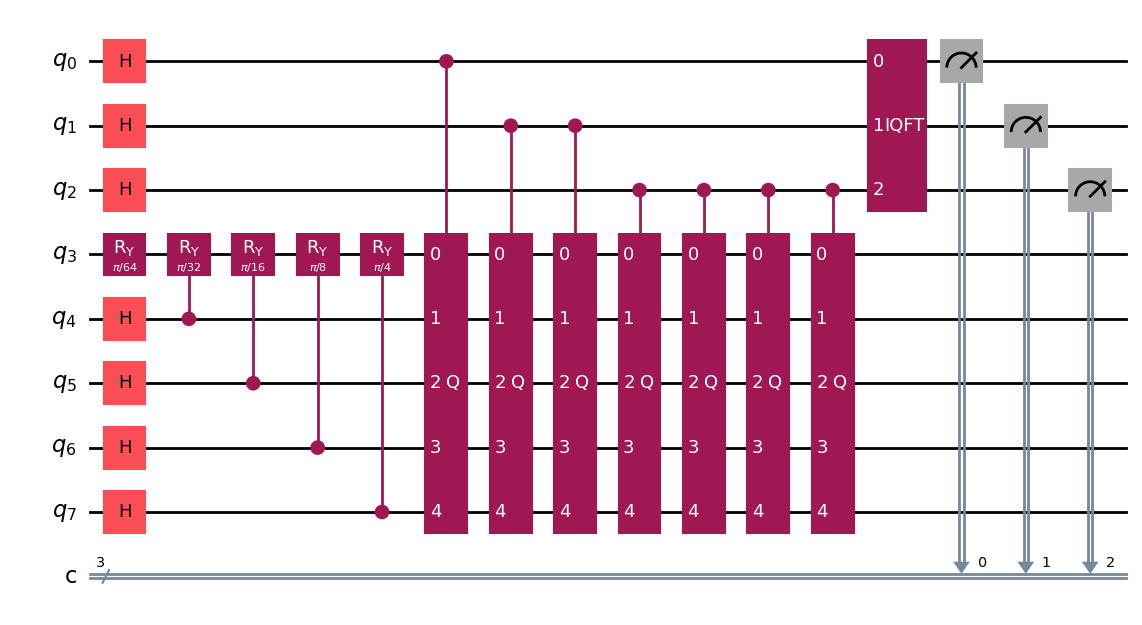

In [6]:
# build circuit
qr = QuantumRegister(8, name='q')
cr = ClassicalRegister(3, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(3))
qc.h([i + 3 for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + 3)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + 3, 0 + 3)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = [
    [0, 3, 4, 5, 6, 7],
    [1, 3, 4, 5, 6, 7],
    [1, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
    [2, 3, 4, 5, 6, 7],
]
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)

# QFT^dagger
qft_dagger = QFT(num_qubits=3, do_swaps=True).inverse()
qc.append(qft_dagger, [0, 1, 2])

# measure
qc.measure([0, 1, 2], [0, 1, 2])

# show
qc.draw('mpl')


### simulator

The frequencies are: {'001': 0.4902, '111': 0.4648, '000': 0.0122, '110': 0.0114, '011': 0.0038, '010': 0.0124, '100': 0.002, '101': 0.0032}
Sum of frequencies: 1.0


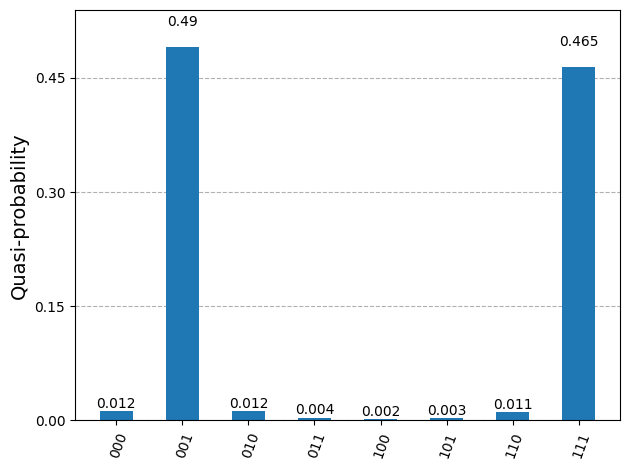

In [7]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)



mathemetic lines : <br>

$\int^1_0 sin^2(\frac{\pi}{4}x)dx = sin^2 (\frac{1 \cdot \pi}{2^3}) = 0.14645$ <br>

$\int^1_0 cos(\frac{\pi}{2}x)dx = 1 - 2 \int^1_0 sin^2(\frac{\pi}{4}x)dx = 0.63662$ <br>

## 4 qubit

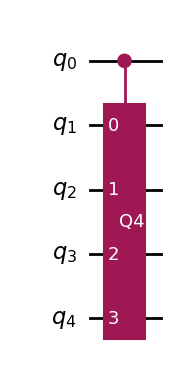

In [8]:
# set to funtion
def custom_block_gate_4():
    block_qc = QuantumCircuit(4, name="Q4")

    # S_phi_0
    block_qc.x(0)
    block_qc.z(0)
    block_qc.x(0)

    # A^dagger
    block_qc.cry(-np.pi/4, 3, 0)
    block_qc.cry(-np.pi/8, 2, 0)
    block_qc.cry(-np.pi/16, 1, 0)
    block_qc.ry(-np.pi/32, 0)
    block_qc.h(range(1, 4))

    # S_0
    block_qc.x(range(4))
    block_qc.h(0)
    block_qc.mcx([1, 2, 3], 0)
    block_qc.h(0)
    block_qc.x(range(4))

    # A
    block_qc.h(range(1, 4))
    block_qc.ry(np.pi/32, 0)
    block_qc.cry(np.pi/16, 1, 0)
    block_qc.cry(np.pi/8, 2, 0)
    block_qc.cry(np.pi/4, 3, 0)

    # change to gate
    return block_qc.to_gate()

# example
qc = QuantumCircuit(5)
block_gate = custom_block_gate_4()
controlled_block = block_gate.control(1)
qc.append(controlled_block, [0, 1, 2, 3, 4])

# show
qc.draw('mpl')


C:\Users\ACER\AppData\Local\Temp\ipykernel_22848\4205009891.py:41: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=4, do_swaps=True).inverse()


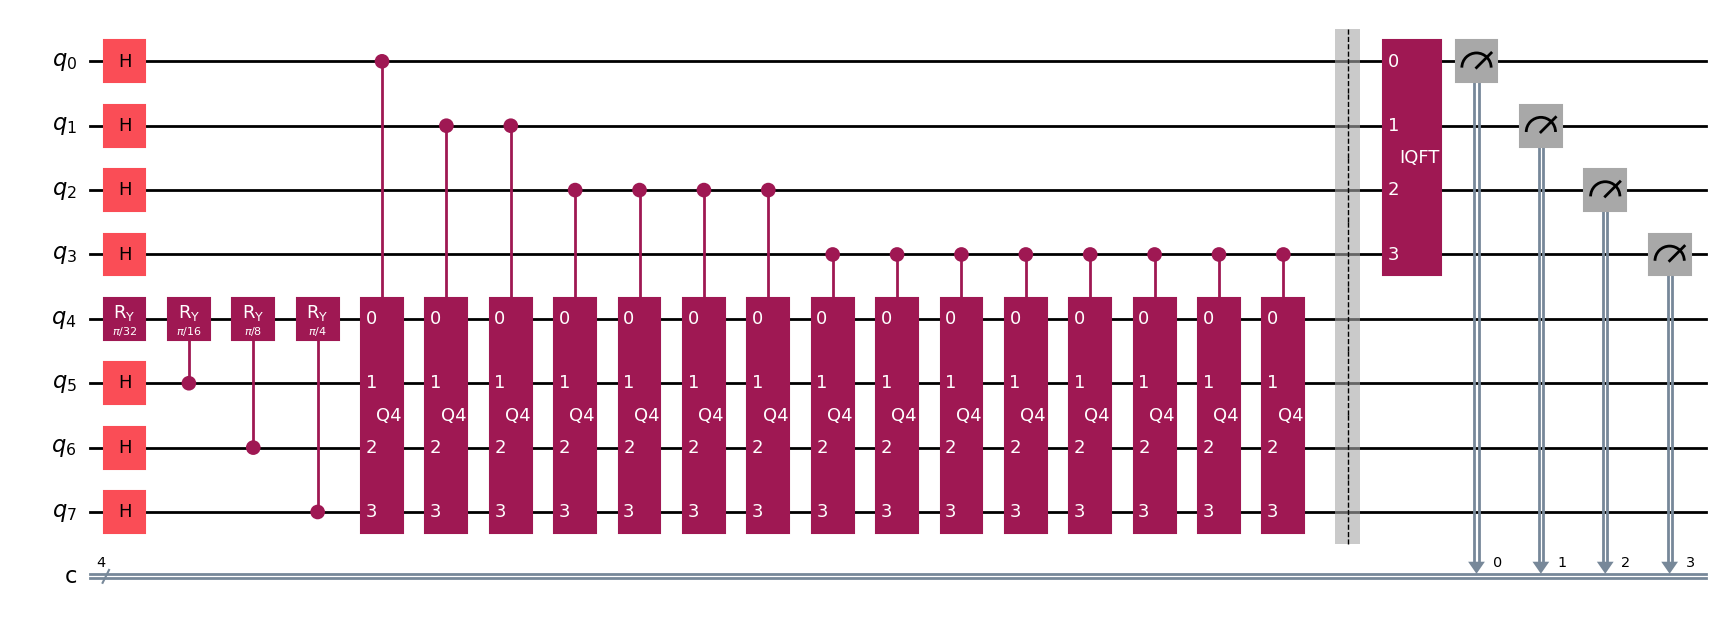

In [9]:
# build circuit
qr = QuantumRegister(8, name='q')
cr = ClassicalRegister(4, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(4))
qc.h([i + 4 for i in range(1, 4)])

# ry 
angles = [np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + 4)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + 4, 0 + 4)

# multiple contorl gate
block_gate = custom_block_gate_4()
controlled_indices = [
    [0, 4, 5, 6, 7],
    [1, 4, 5, 6, 7],
    [1, 4, 5, 6, 7],
    [2, 4, 5, 6, 7],
    [2, 4, 5, 6, 7],
    [2, 4, 5, 6, 7],
    [2, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
    [3, 4, 5, 6, 7],
]
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)

qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=4, do_swaps=True).inverse()
qc.append(qft_dagger, [0, 1, 2, 3])

# measure
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])

# show
qc.draw('mpl')


### simulator

The frequencies are: {'1110': 0.4096, '0010': 0.4156, '0011': 0.0404, '1111': 0.0164, '1101': 0.048, '0001': 0.019, '0100': 0.0082, '1011': 0.0044, '1000': 0.0026, '0000': 0.0096, '0110': 0.0028, '1100': 0.0106, '0101': 0.0052, '1001': 0.0028, '0111': 0.0028, '1010': 0.002}
Sum of frequencies: 1.0000000000000002


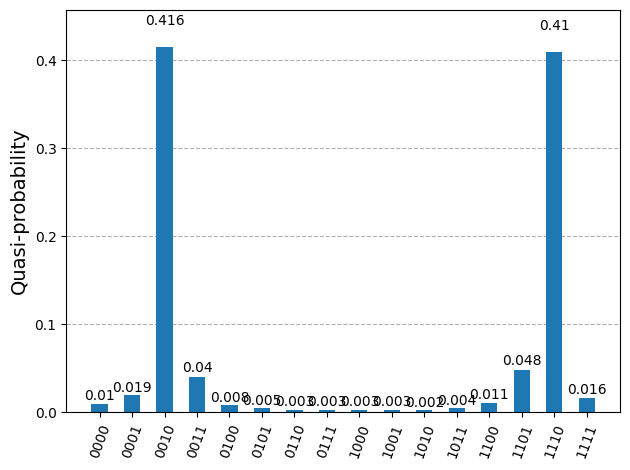

In [10]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)



mathemetic lines : <br>

$\int^1_0 sin^2(\frac{\pi}{4}x)dx = sin^2 (\frac{2 \cdot \pi}{2^4}) = 0.14645$ <br>

$\int^1_0 cos(\frac{\pi}{2}x)dx = 1 - 2 \int^1_0 sin^2(\frac{\pi}{4}x)dx = 0.63662$ <br>

## 5 qubit
we cahnge into functions to easily build circuit

C:\Users\ACER\AppData\Local\Temp\ipykernel_22848\792500311.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()


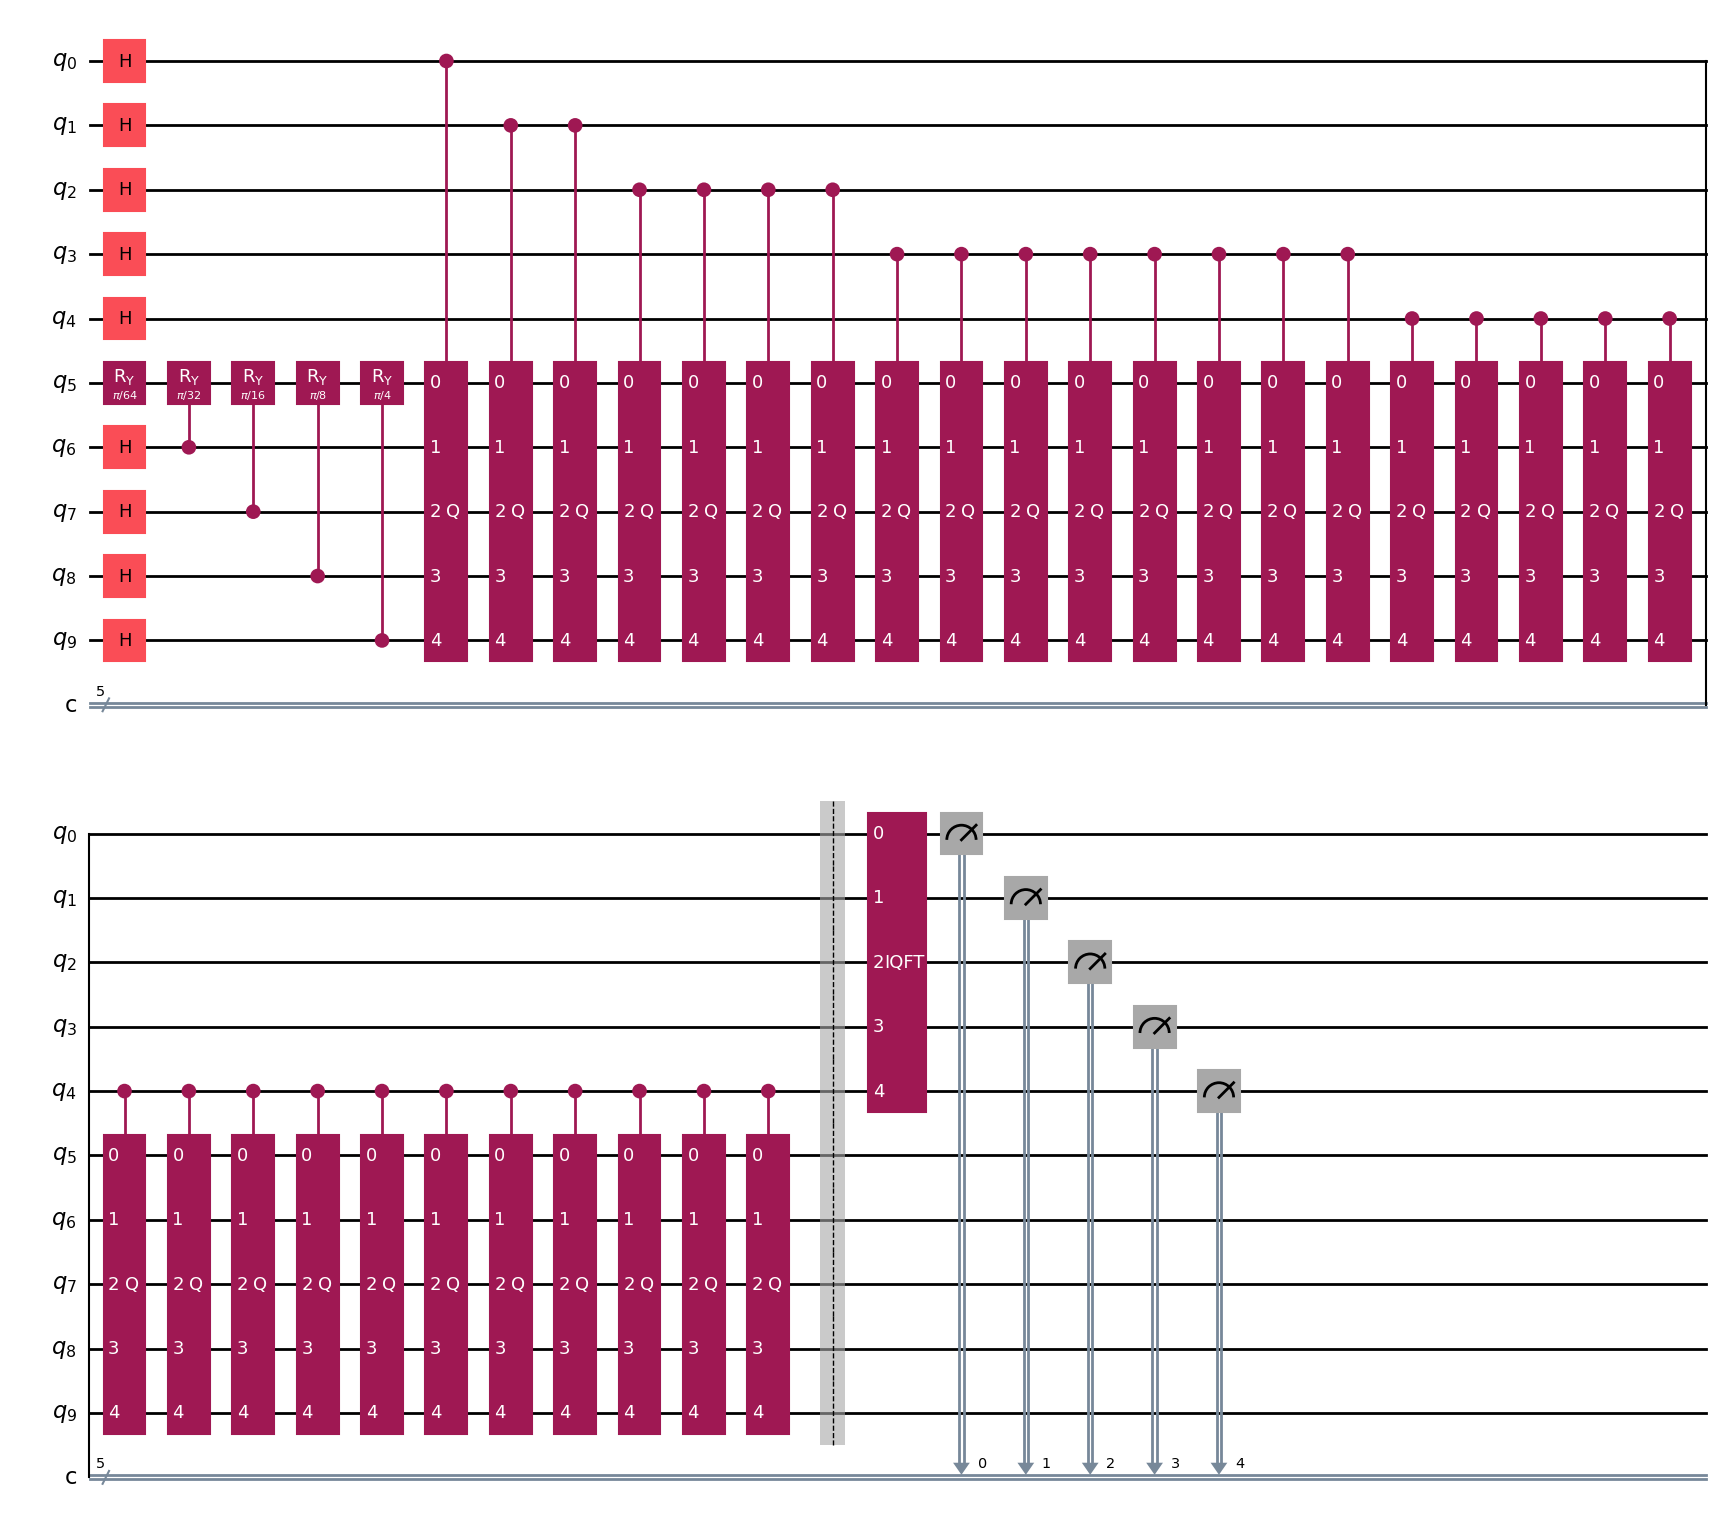

In [11]:
# set qubit we want to know
qqq = 5

# build circuit
qr = QuantumRegister(qqq+5, name='q')
cr = ClassicalRegister(qqq, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(qqq))
qc.h([i + qqq for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + qqq)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + qqq, 0 + qqq)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = []
for control in range(0, qqq):
    repeat_times = 2 ** control
    for _ in range(repeat_times):
        controlled_indices.append([control] + list(range(qqq, qqq +5)))
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)
qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
qc.append(qft_dagger, list(range(0, qqq)))

# measure
qc.measure(range(qqq), range(qqq))

# show
qc.draw('mpl')


### simulate

The frequencies are: {'11011': 0.1888, '11100': 0.2096, '00010': 0.0088, '00101': 0.1938, '11101': 0.0228, '00100': 0.2166, '00001': 0.0068, '10111': 0.0038, '11111': 0.0068, '00011': 0.0254, '10010': 0.0018, '11001': 0.0082, '11010': 0.027, '11000': 0.0058, '00110': 0.0204, '10101': 0.0028, '01000': 0.0048, '11110': 0.0106, '01111': 0.0014, '00000': 0.0062, '00111': 0.0092, '01010': 0.0028, '10110': 0.0032, '01011': 0.0016, '01001': 0.0028, '10001': 0.0014, '01100': 0.0008, '10000': 0.0008, '10100': 0.0012, '01101': 0.0016, '01110': 0.0014, '10011': 0.001}
Sum of frequencies: 1.0000000000000002


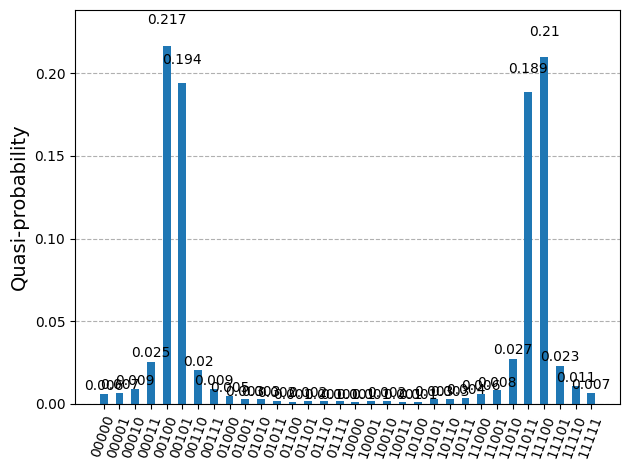

In [12]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)



## 6 qubit with simulate

C:\Users\ACER\AppData\Local\Temp\ipykernel_22848\3679763078.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()


The frequencies are: {'110111': 0.4934, '001001': 0.5022, '111101': 0.0002, '001010': 0.0004, '111100': 0.0004, '110110': 0.0008, '111000': 0.001, '010011': 0.0002, '001000': 0.0008, '111010': 0.0002, '011110': 0.0002, '001111': 0.0002}
Sum of frequencies: 0.9999999999999999


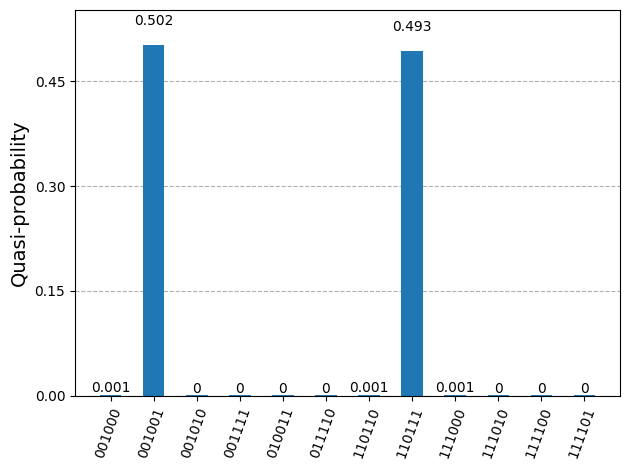

In [13]:
# set qubit we want to know
qqq = 6

# build circuit
qr = QuantumRegister(qqq+5, name='q')
cr = ClassicalRegister(qqq, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(qqq))
qc.h([i + qqq for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + qqq)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + qqq, 0 + qqq)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = []
for control in range(0, qqq):
    repeat_times = 2 ** control
    for _ in range(repeat_times):
        controlled_indices.append([control] + list(range(qqq, qqq +5)))
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)
qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
qc.append(qft_dagger, list(range(0, qqq)))

# measure
qc.measure(range(qqq), range(qqq))

# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)




mathemetic lines : <br>

$\int^1_0 sin^2(\frac{\pi}{4}x)dx = sin^2 (\frac{9 \cdot \pi}{2^6}) = 0.183247$ <br>

$\int^1_0 cos(\frac{\pi}{2}x)dx = 1 - 2 \int^1_0 sin^2(\frac{\pi}{4}x)dx = 0.6335$ <br>

## caculate |1> state

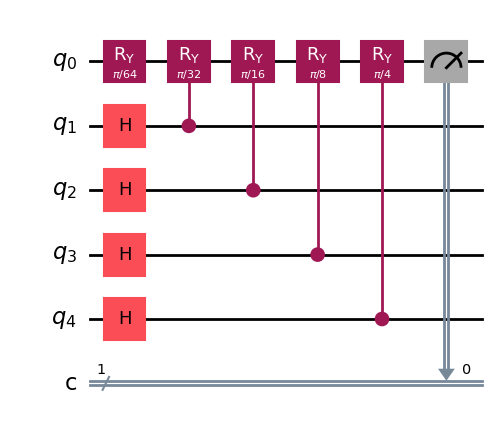

In [14]:
# build circuit
qr = QuantumRegister(5, name='q')
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr, cr)

qc.h(range(1, 5))

# set angles
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i, 0)
# measure
qc.measure(0, 0)

# show
qc.draw('mpl')


### simulator

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=100000, num_bits=1>)), metadata={'shots': 100000, 'circuit_metadata': {}})], metadata={'version': 2})
The frequencies are: {'0': 0.81912, '1': 0.18088}
Sum of frequencies: 1.0


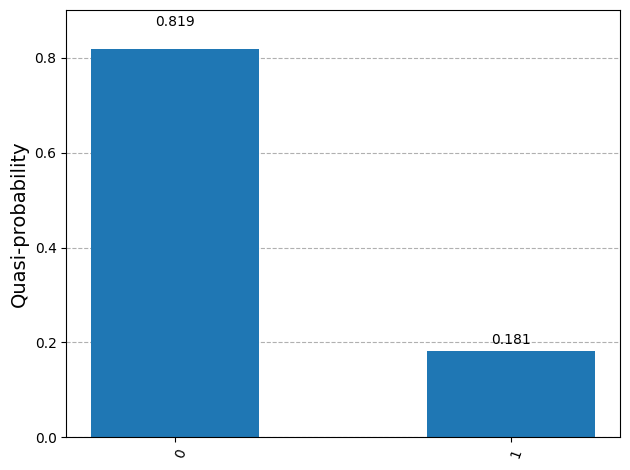

In [15]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 100000)]).result()

# access result for pub 0
data_pub = result[0].data
print(result)
# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)



# build function to caculate error(MLE???)

$I = sin^2(\theta)$ <br>
$\epsilon_I \approx 2 \sqrt{I} \cdot \sqrt{1-I} \epsilon_{\theta} =$
$2 \sqrt{I(1-I)} \cdot \frac{\pi}{2^n} \propto \frac{1}{N}$

In [16]:
# we already find freq
freq = frequencies

def caculate_I(freq, qqq):
    I = sum(
    freq[k] * np.sin(int(k, 2) * np.pi / 2**(qqq)) ** 2
    for k in freq)
    return I


I = caculate_I(freq, qqq)
print(I)


0.00043549331976651363


In [17]:
def caculate_epsi_I(I, qqq):
    epsi_I = np.pi * np.sqrt(I * (1 - I)) / (2 ** (qqq - 1))
    return epsi_I

epsi_I = caculate_epsi_I(I, qqq)
print(epsi_I)

0.0020483117503355464


## try 7 qubit and caculate

In [18]:
# set qubit we want to know
qqq = 7

# build circuit
qr = QuantumRegister(qqq+5, name='q')
cr = ClassicalRegister(qqq, name='c')
qc = QuantumCircuit(qr, cr)

# init
qc.h(range(qqq))
qc.h([i + qqq for i in range(1, 5)])

# ry 
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0 + qqq)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i + qqq, 0 + qqq)

# multiple contorl gate
block_gate = custom_block_gate()
controlled_indices = []
for control in range(0, qqq):
    repeat_times = 2 ** control
    for _ in range(repeat_times):
        controlled_indices.append([control] + list(range(qqq, qqq +5)))
for indices in controlled_indices:
    qc.append(block_gate.control(1), indices)
qc.barrier()

# QFT^dagger
qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
qc.append(qft_dagger, list(range(0, qqq)))

# measure
qc.measure(range(qqq), range(qqq))

# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 5000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)

freq = frequencies
I = caculate_I(freq, qqq)
print("I :", I)
epsi_I = caculate_epsi_I(I, qqq)
print("epsi_I :", epsi_I)



C:\Users\ACER\AppData\Local\Temp\ipykernel_22848\3289991464.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()


The frequencies are: {'0010010': 0.5038, '1101110': 0.4836, '1101011': 0.0006, '0010011': 0.0016, '1100111': 0.0002, '1101101': 0.001, '0010001': 0.002, '1101111': 0.0022, '0011011': 0.0002, '1101100': 0.0006, '0000010': 0.0002, '0000110': 0.0006, '1100110': 0.0002, '0010110': 0.0002, '1110001': 0.0004, '0010000': 0.0008, '0001111': 0.0004, '0010100': 0.0006, '0011001': 0.0002, '1110010': 0.0002, '1101010': 0.0002, '0010101': 0.0002}
Sum of frequencies: 1.0
I : 0.18281826088480108
epsi_I : 0.018973131290741397


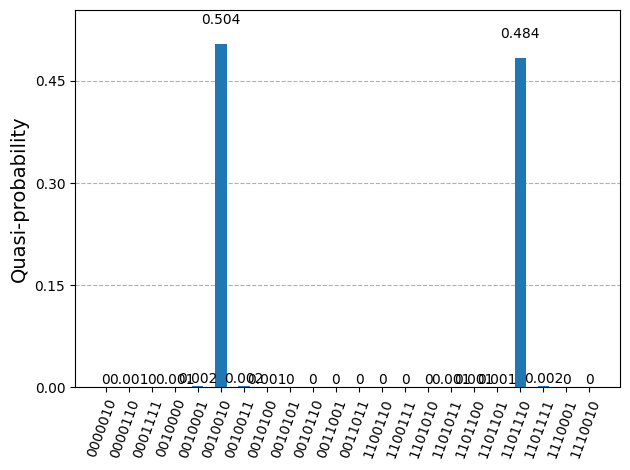

In [19]:
plot_histogram(frequencies)


# qqq = 3~15

In [ ]:
results_list = []

for qqq in range(3, 12):  # qqq = 3 ~ 11
    # 建立量子電路
    qr = QuantumRegister(qqq + 5, name='q')
    cr = ClassicalRegister(qqq, name='c')
    qc = QuantumCircuit(qr, cr)

    # 初始化
    qc.h(range(qqq))
    qc.h([i + qqq for i in range(1, 5)])

    # ry + cry
    angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
    qc.ry(angles[0], 0 + qqq)
    for i, angle in enumerate(angles[1:], start=1):
        qc.cry(angle, i + qqq, 0 + qqq)

    # multiple control gate
    block_gate = custom_block_gate()
    controlled_indices = []
    for control in range(0, qqq):
        repeat_times = 2 ** control
        for _ in range(repeat_times):
            controlled_indices.append([control] + list(range(qqq, qqq + 5)))
    for indices in controlled_indices:
        qc.append(block_gate.control(1), indices)
    qc.barrier()

    # QFT^dagger
    qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
    qc.append(qft_dagger, list(range(0, qqq)))

    # 測量
    qc.measure(range(qqq), range(qqq))

    # 執行
    sampler = StatevectorSampler()
    result = sampler.run([(qc, None, 100)]).result()
    data_pub = result[0].data
    counts = data_pub.c.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # 計算 I 與 epsilon_I
    I = caculate_I(frequencies, qqq)
    epsi_I = caculate_epsi_I(I, qqq)

    # 存成列表
    results_list.append({
        "qqq": qqq,
        "I": I,
        "epsi_I": epsi_I
    })

# 轉成 DataFrame
df = pd.DataFrame(results_list)
df


C:\Users\ACER\AppData\Local\Temp\ipykernel_32232\27147293.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
C:\Users\ACER\AppData\Local\Temp\ipykernel_32232\27147293.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=qqq, do_swaps=True).inverse()
C:\Users\ACER\AppData\Local\Temp\ipykernel_32232\27147293.py:31: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. (

,qqq,I,epsi_I
0,3,0.148518,0.279297
1,4,0.172841,0.148484
2,5,0.193013,0.077492
3,6,0.182803,0.037945
4,7,0.182803,0.018973
5,8,0.182807,0.009486
6,9,0.183325,0.004748
7,10,0.181552,0.002365
8,11,0.181619,0.001183


# df

In [ ]:
df = df.rename(columns={"qqq": "qpe_qubit", "I": "estimate_result"})
df

,qpe_qubit,estimate_result,epsi_I
0,3,0.148518,0.279297
1,4,0.172841,0.148484
2,5,0.193013,0.077492
3,6,0.182803,0.037945
4,7,0.182803,0.018973
5,8,0.182807,0.009486
6,9,0.183325,0.004748
7,10,0.181552,0.002365
8,11,0.181619,0.001183


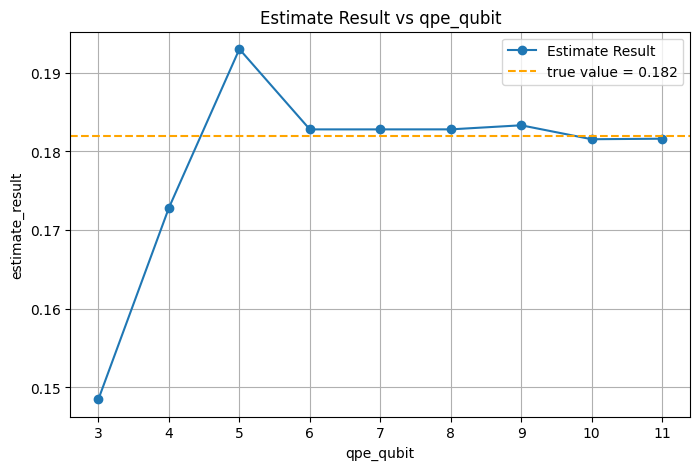

In [22]:
df = df.rename(columns={"qqq": "qpe_qubit", "I": "estimate_result"})

plt.figure(figsize=(8, 5))
plt.plot(df["qpe_qubit"], df["estimate_result"], marker="o", label="Estimate Result")
plt.axhline(y=0.182, color="orange", linestyle="--", label="true value = 0.182")  # 加橘色橫線
plt.xlabel("qpe_qubit")
plt.ylabel("estimate_result")
plt.title("Estimate Result vs qpe_qubit")
plt.grid(True)
plt.legend()
plt.show()



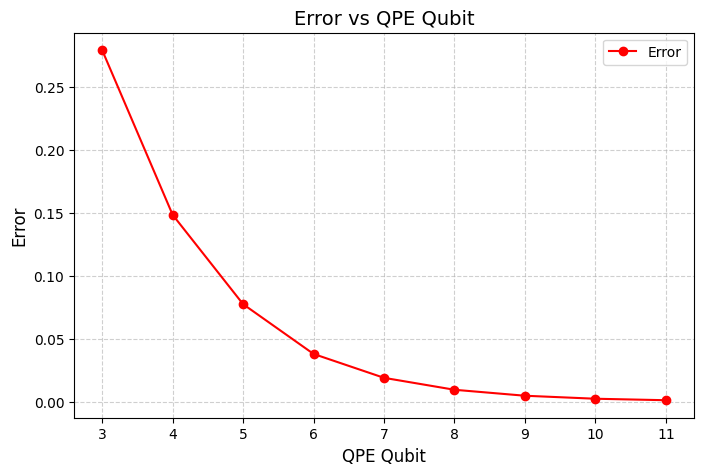

In [23]:
# 準備資料
df_plot2 = df.rename(columns={"qqq": "qpe_qubit", "epsi_I": "error"})

# 畫圖
plt.figure(figsize=(8, 5))
plt.plot(df_plot2["qpe_qubit"], df_plot2["error"], marker='o', color='red', label='Error')

plt.xlabel("QPE Qubit", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.title("Error vs QPE Qubit", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


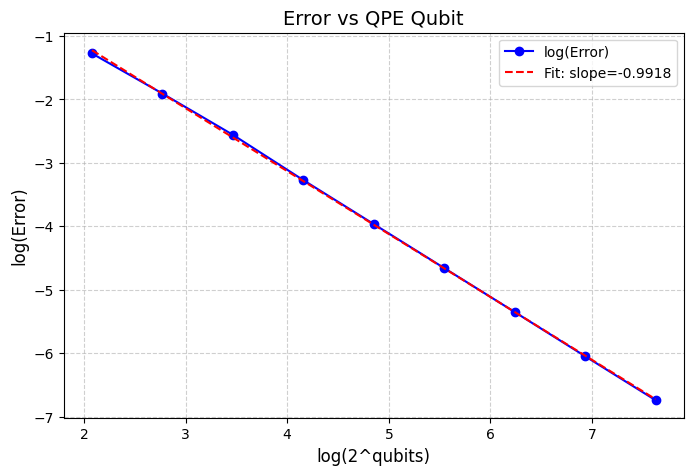

In [25]:
# 準備資料

df_plot2 = df.rename(columns={"qqq": "qpe_qubit", "epsi_I": "error"})

# 新增 log 值
df3 = df_plot2.copy()
df3["log_error"] = np.log(df3["error"])
df3["log_2_qubits"] = np.log(2 ** df3["qpe_qubit"])

# 計算斜率 (線性擬合)
slope, intercept = np.polyfit(df3["log_2_qubits"], df3["log_error"], 1)

# 作圖
plt.figure(figsize=(8, 5))
plt.plot(df3["log_2_qubits"], df3["log_error"], marker='o', color='blue', label='log(Error)')
plt.plot(df3["log_2_qubits"], slope * df3["log_2_qubits"] + intercept, linestyle='--', color='red',
         label=f'Fit: slope={slope:.4f}')

plt.xlabel("log(2^qubits)", fontsize=12)
plt.ylabel("log(Error)", fontsize=12)
plt.title("Error vs QPE Qubit", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

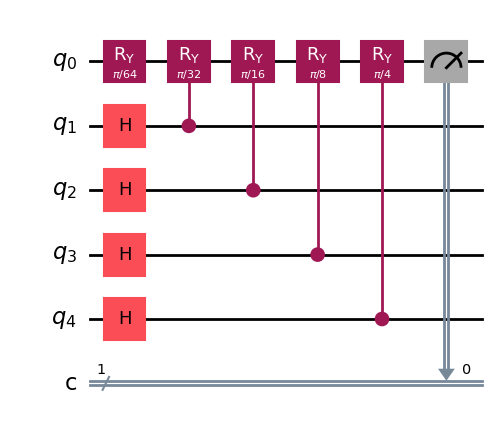

In [26]:
# build circuit
qr = QuantumRegister(5, name='q')
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr, cr)

qc.h(range(1, 5))

# set angles
angles = [np.pi/64, np.pi/32, np.pi/16, np.pi/8, np.pi/4]
qc.ry(angles[0], 0)
for i, angle in enumerate(angles[1:], start=1):
    qc.cry(angle, i, 0)
# measure
qc.measure(0, 0)

# show
qc.draw('mpl')


In [ ]:
# run on statevectorsampler
sampler = StatevectorSampler()
# set shot=5000
result = sampler.run([(qc, None, 100000)]).result()

# access result for pub 0
data_pub = result[0].data

# get counts for classical
counts = data_pub.c.get_counts()
total_shots = sum(counts.values())
frequencies = {k: v / total_shots for k, v in counts.items()}
print(f"The frequencies are: {frequencies}")
print(f"Sum of frequencies: {sum(frequencies.values())}")
plot_histogram(frequencies)




In [27]:
c_shot_list = []
for i in range(3,12):
    c_shot = 2**(i+1) -1
    c_shot_list.append(c_shot)
print(c_shot_list)

[15, 31, 63, 127, 255, 511, 1023, 2047, 4095]


In [ ]:
results_list = []
for c_shot in c_shot_list:
    # run on statevectorsampler
    sampler = StatevectorSampler()
    # set shot=5000
    result = sampler.run([(qc, None, c_shot)]).result()

    # access result for pub 0
    data_pub = result[0].data

    # get counts for classical
    counts = data_pub.c.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # 存成列表
    results_list.append({
        "c_shot": c_shot,
        "freq": frequencies,

    })

results_list


[{'c_shot': 15, 'freq': {'1': 0.3333333333333333, '0': 0.6666666666666666}},
 {'c_shot': 31, 'freq': {'0': 0.7419354838709677, '1': 0.25806451612903225}},
 {'c_shot': 63, 'freq': {'0': 0.8253968253968254, '1': 0.1746031746031746}},
 {'c_shot': 127, 'freq': {'0': 0.8110236220472441, '1': 0.1889763779527559}},
 {'c_shot': 255, 'freq': {'0': 0.796078431372549, '1': 0.20392156862745098}},
 {'c_shot': 511, 'freq': {'0': 0.8434442270058709, '1': 0.15655577299412915}},
 {'c_shot': 1023, 'freq': {'0': 0.8123167155425219, '1': 0.187683284457478}},
 {'c_shot': 2047, 'freq': {'0': 0.8153395212506106, '1': 0.18466047874938935}},
 {'c_shot': 4095, 'freq': {'0': 0.8170940170940171, '1': 0.1829059829059829}}]

real value = $\sum^{(2^4-1)}_{i=0}sin^2(\frac{\pi}{64}i+\frac{\pi}{128})*\frac{1}{16}$

In [ ]:
i = np.arange(16)
real_value = np.sum(np.sin(np.pi/64 * i + np.pi/128)**2 * (1/16))




0.1815622461391232

$\sqrt{\frac{1}{M} \sum^M_{i=1}(realvalue - a_i)^2}$

In [39]:
classical_df = pd.DataFrame([
    {"c_shot": item["c_shot"], "I": item["freq"].get("1", 0)}
    for item in results_list
])

# 計算 epsi_I 並新增欄位
classical_df["epsi_I"] = np.pi * np.sqrt(classical_df["I"] * (1 - classical_df["I"])) / classical_df["c_shot"]

classical_df




,c_shot,I,epsi_I
0,15,0.333333,0.098731
1,31,0.258065,0.044344
2,63,0.174603,0.018931
3,127,0.188976,0.009684
4,255,0.203922,0.004964
5,511,0.156556,0.002234
6,1023,0.187683,0.001199
7,2047,0.184660,0.000596
8,4095,0.182906,0.000297


In [ ]:
M = 100

# caculate real_value
i = np.arange(16)
real_value = np.sum(np.sin(np.pi/64 * i + np.pi/128)**2 * (1/16))

results_list = []

for c_shot in c_shot_list:
    I_list = []
    
    for _ in range(M):
        # run on statevectorsampler
        sampler = StatevectorSampler()
        result = sampler.run([(qc, None, c_shot)]).result()

        # access result for pub 0
        data_pub = result[0].data

        # get counts for classical
        counts = data_pub.c.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}

        # freq for "1"
        I_list.append(frequencies.get('1', 0))
    
    # caculate rmse
    error = np.sqrt(np.mean([(real_value - I_i)**2 for I_i in I_list]))
    
    # to list
    results_list.append({
        "c_shot": c_shot,
        "error": error
    })

# to df
error_df = pd.DataFrame(results_list)
error_df


,c_shot,error
0,15,0.099415
1,31,0.072818
2,63,0.047274
3,127,0.037665
4,255,0.027551
5,511,0.019226
6,1023,0.013742
7,2047,0.008105
8,4095,0.006142


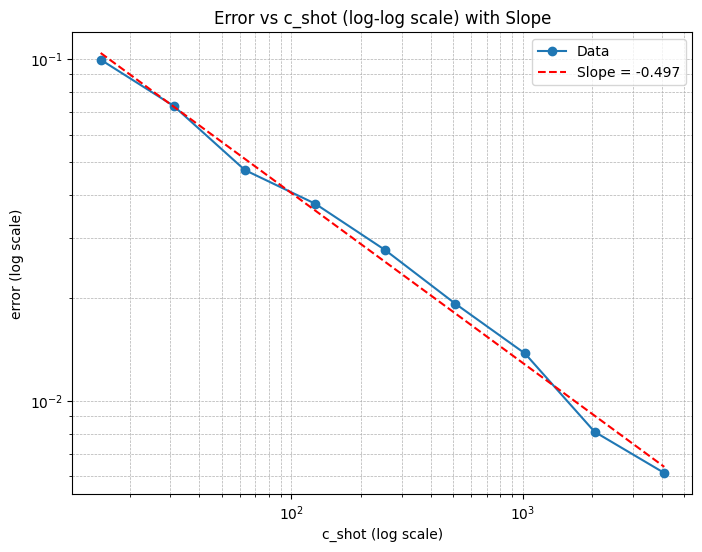

In [ ]:
# caculate log slope
log_x = np.log(error_df["c_shot"])
log_y = np.log(error_df["error"])
slope, intercept = np.polyfit(log_x, log_y, 1)

# plot
plt.figure(figsize=(8, 6))
plt.plot(error_df["c_shot"], error_df["error"], marker='o', linestyle='-', label="Data")
plt.xscale("log")
plt.yscale("log")

# add slope
fit_y = np.exp(intercept) * error_df["c_shot"]**slope
plt.plot(error_df["c_shot"], fit_y, linestyle="--", color="red", label=f"Slope = {slope:.3f}")

plt.xlabel("c_shot (log scale)")
plt.ylabel("error (log scale)")
plt.title("Error vs c_shot (log-log scale) with Slope")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()




# combine together

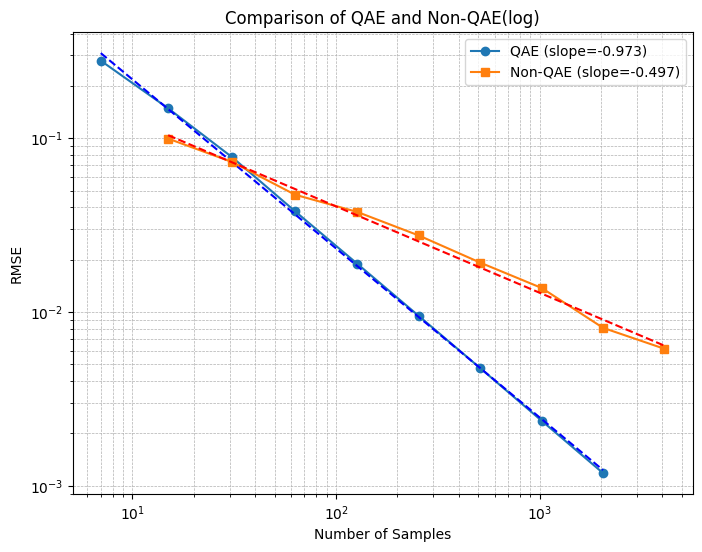

In [45]:

# 第一組資料
df_plot2 = df.rename(columns={"qqq": "qpe_qubit", "epsi_I": "error"})

# 新增 c_shot 與 log 值
df3 = df_plot2.copy()
df3["c_shot"] = 2 ** df3["qpe_qubit"] - 1

# 計算第一組資料的回歸線 (log-log)
log_x1 = np.log(df3["c_shot"])
log_y1 = np.log(df3["error"])
slope1, intercept1 = np.polyfit(log_x1, log_y1, 1)
fit_y1 = np.exp(intercept1) * df3["c_shot"]**slope1

# 第二組資料
# 計算第二組資料的回歸線 (log-log)
log_x2 = np.log(error_df["c_shot"])
log_y2 = np.log(error_df["error"])
slope2, intercept2 = np.polyfit(log_x2, log_y2, 1)
fit_y2 = np.exp(intercept2) * error_df["c_shot"]**slope2

# 疊圖
plt.figure(figsize=(8, 6))

# 第一組資料
plt.plot(df3["c_shot"], df3["error"], marker='o', linestyle='-', label=f"QAE (slope={slope1:.3f})")
plt.plot(df3["c_shot"], fit_y1, linestyle="--", color="blue")

# 第二組資料
plt.plot(error_df["c_shot"], error_df["error"], marker='s', linestyle='-', label=f"Non-QAE (slope={slope2:.3f})")
plt.plot(error_df["c_shot"], fit_y2, linestyle="--", color="red")

# log-log 設定
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number of Samples")
plt.ylabel("RMSE")
plt.title("Comparison of QAE and Non-QAE(log)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


# new function
function : $cos(\theta) = 1 - 2sin^2(\frac{\theta}{2})$ <br>
set $P = 0.6$ <br>

In [268]:
P = 0.8
phi = 2 * np.arccos(np.sqrt(P))
print(phi)


0.9272952180016123


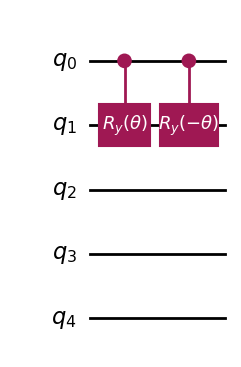

In [269]:
# set to funtion
def control_pos_ry_gate(theta):
    block_qc = QuantumCircuit(1, name=r"$R_y(\theta)$")
    block_qc.ry(theta, 0)

    # change to gate
    return block_qc.to_gate()

def control_neg_ry_gate(theta):
    block_qc = QuantumCircuit(1, name=r"$R_y(-\theta)$")
    block_qc.ry(-theta, 0)

    # change to gate
    return block_qc.to_gate()

# example
qc = QuantumCircuit(5)
block_gate = control_pos_ry_gate(P)
controlled_block = block_gate.control(1)
qc.append(controlled_block, [0, 1])
block_gate = control_neg_ry_gate(P)
controlled_block = block_gate.control(1)
qc.append(controlled_block, [0, 1])

# show
qc.draw('mpl')


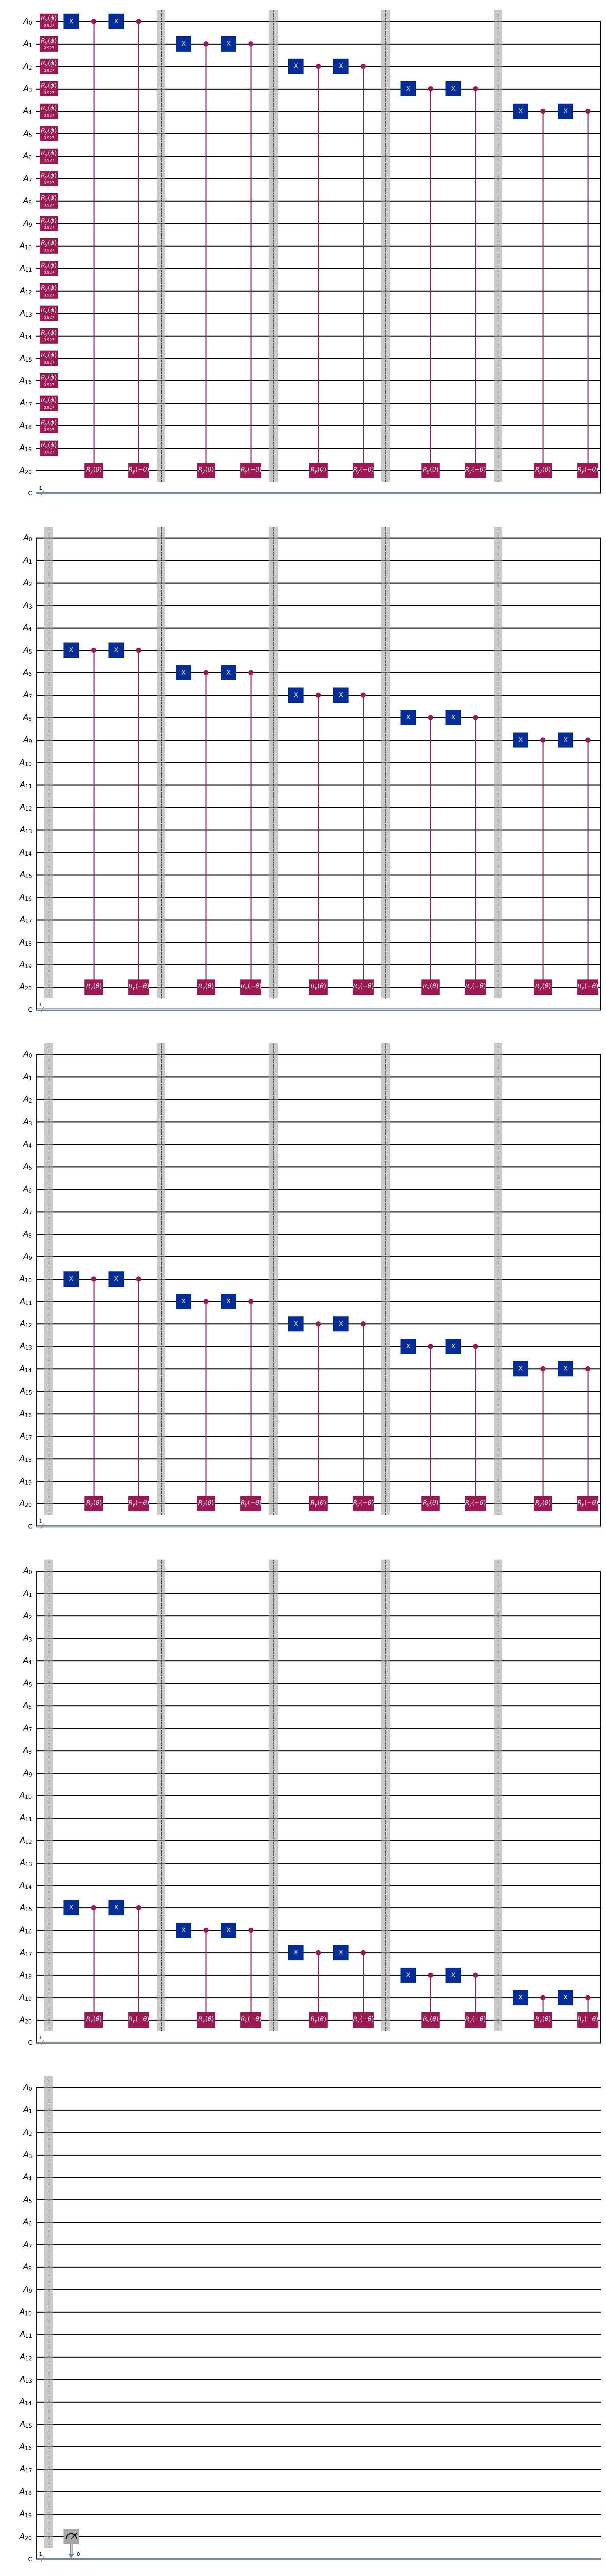

In [271]:
theta = np.pi
step = 20
qr = QuantumRegister(step+1, name='A')
cr = ClassicalRegister(1, name='c')
qc_A = QuantumCircuit(qr,cr)

# Ry(phi) for first 4 qubits
qc_A.ry(phi, range(step), r"$R_y(\phi)$")

# 重複 step1 ~ step4
for ctrl_qubit in range(step):
    qc_A.x(ctrl_qubit)
    
    c_pos_gate = control_pos_ry_gate(theta).control(1)
    qc_A.append(c_pos_gate, [ctrl_qubit, step])
    
    qc_A.x(ctrl_qubit)
    
    c_neg_gate = control_neg_ry_gate(theta).control(1)
    qc_A.append(c_neg_gate, [ctrl_qubit, step])
    
    qc_A.barrier()

qc_A.measure(step, 0)


# show
qc_A.draw('mpl')


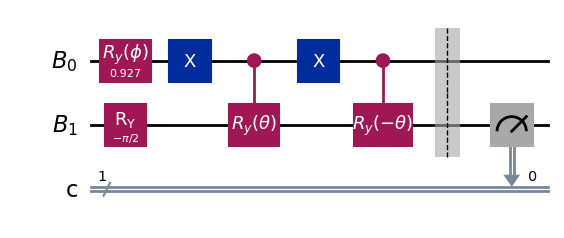

In [272]:
theta = np.pi
step = 1
qr = QuantumRegister(step+1, name='B')
cr = ClassicalRegister(1, name='c')
qc_B = QuantumCircuit(qr, cr)

# Ry(phi) for first 4 qubits
qc_B.ry(phi, range(step), r"$R_y(\phi)$")
qc_B.ry(-np.pi/2, step)


# 重複 step1 ~ step4
for ctrl_qubit in range(step):
    qc_B.x(ctrl_qubit)
    
    c_pos_gate = control_pos_ry_gate(theta).control(1)
    qc_B.append(c_pos_gate, [ctrl_qubit, step])
    
    qc_B.x(ctrl_qubit)
    
    c_neg_gate = control_neg_ry_gate(theta).control(1)
    qc_B.append(c_neg_gate, [ctrl_qubit, step])
    
    qc_B.barrier()

qc_B.measure(step,0)


# show
qc_B.draw('mpl')




cut into 17 slice --> 2 * 8 + 1

# sample

## part A

In [273]:
# 建立 theta 序列
theta_values = np.linspace(-np.pi, np.pi, 51)

step = 20
results_list = []

for theta in theta_values:
    # 建立電路
    qr = QuantumRegister(step + 1, name='A')
    cr = ClassicalRegister(1, name='c_A')
    qc_A = QuantumCircuit(qr, cr)

    # Ry(phi) for first step qubits
    qc_A.ry(phi, range(step), r"$R_y(\phi)$")

    # 重複 step1~stepN
    for ctrl_qubit in range(step):
        qc_A.x(ctrl_qubit)

        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_A.append(c_pos_gate, [ctrl_qubit, step])

        qc_A.x(ctrl_qubit)

        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_A.append(c_neg_gate, [ctrl_qubit, step])

        qc_A.barrier()
    qc_A.measure(step, 0)
    # run on statevectorsampler

    


    
    sampler = StatevectorSampler()
    result = sampler.run([(qc_A, None, 10000)]).result()




    # access result
    data_pub = result[0].data
    counts = data_pub.c_A.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # 取測量結果 '1' 的機率當作觀測值（或你可改成其他 key）
    I = frequencies.get('1', 0)

    results_list.append({
        "theta": theta,
        "freq_1": I
    })

# 轉成 DataFrame
df_A_v_17 = pd.DataFrame(results_list)
print(df_A_v_17)




           theta  freq_1
0  -3.141593e+00  0.0000
1  -3.015929e+00  0.4724
2  -2.890265e+00  0.8324
3  -2.764602e+00  0.5085
4  -2.638938e+00  0.3970
5  -2.513274e+00  0.5204
6  -2.387610e+00  0.5112
7  -2.261947e+00  0.4970
8  -2.136283e+00  0.4972
9  -2.010619e+00  0.5018
10 -1.884956e+00  0.4974
11 -1.759292e+00  0.5055
12 -1.633628e+00  0.5047
13 -1.507964e+00  0.4922
14 -1.382301e+00  0.4927
15 -1.256637e+00  0.5061
16 -1.130973e+00  0.5025
17 -1.005310e+00  0.5032
18 -8.796459e-01  0.4924
19 -7.539822e-01  0.5122
20 -6.283185e-01  0.5098
21 -5.026548e-01  0.3967
22 -3.769911e-01  0.5024
23 -2.513274e-01  0.8350
24 -1.256637e-01  0.4748
25  4.440892e-16  0.0000
26  1.256637e-01  0.4815
27  2.513274e-01  0.8279
28  3.769911e-01  0.5073
29  5.026548e-01  0.4039
30  6.283185e-01  0.5095
31  7.539822e-01  0.5048
32  8.796459e-01  0.4986
33  1.005310e+00  0.4999
34  1.130973e+00  0.4961
35  1.256637e+00  0.5093
36  1.382301e+00  0.4996
37  1.507964e+00  0.4990
38  1.633628e+00  0.4994


## part B

           theta  freq_1
0  -3.141593e+00  0.4995
1  -3.015929e+00  0.0456
2  -2.890265e+00  0.4703
3  -2.764602e+00  0.7040
4  -2.638938e+00  0.4979
5  -2.513274e+00  0.4741
6  -2.387610e+00  0.5083
7  -2.261947e+00  0.5034
8  -2.136283e+00  0.5002
9  -2.010619e+00  0.4898
10 -1.884956e+00  0.5006
11 -1.759292e+00  0.5164
12 -1.633628e+00  0.4999
13 -1.507964e+00  0.4975
14 -1.382301e+00  0.5001
15 -1.256637e+00  0.4986
16 -1.130973e+00  0.5052
17 -1.005310e+00  0.4977
18 -8.796459e-01  0.4898
19 -7.539822e-01  0.4773
20 -6.283185e-01  0.5299
21 -5.026548e-01  0.5161
22 -3.769911e-01  0.3036
23 -2.513274e-01  0.5244
24 -1.256637e-01  0.9540
25  4.440892e-16  0.5013
26  1.256637e-01  0.0485
27  2.513274e-01  0.4632
28  3.769911e-01  0.6992
29  5.026548e-01  0.4937
30  6.283185e-01  0.4611
31  7.539822e-01  0.5143
32  8.796459e-01  0.4890
33  1.005310e+00  0.5006
34  1.130973e+00  0.5053
35  1.256637e+00  0.5036
36  1.382301e+00  0.5057
37  1.507964e+00  0.4979
38  1.633628e+00  0.5043


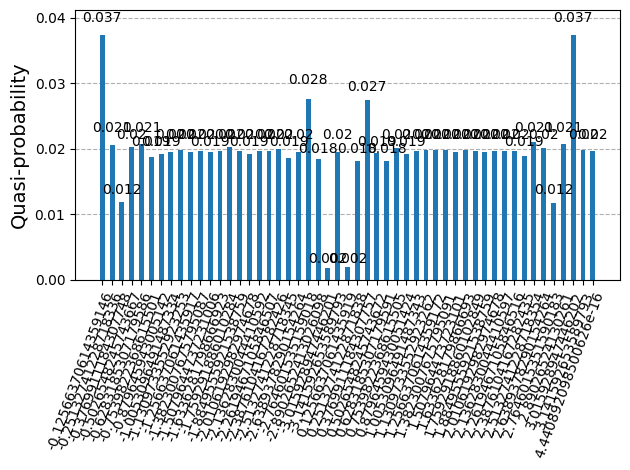

In [274]:
# 建立 theta 序列
theta_values = np.linspace(-np.pi, np.pi, 51)

step = 20
results_list = []

for theta in theta_values:
    # 建立電路
    qr = QuantumRegister(step + 1, name='B')
    cr = ClassicalRegister(1, name='c_B')
    qc_B = QuantumCircuit(qr, cr)

    # Ry(phi) for first step qubits
    qc_B.ry(phi, range(step), r"$R_y(\phi)$")
    qc_B.ry(-np.pi/2, step)

    # 重複 step1~stepN
    for ctrl_qubit in range(step):
        qc_B.x(ctrl_qubit)

        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_B.append(c_pos_gate, [ctrl_qubit, step])

        qc_B.x(ctrl_qubit)

        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_B.append(c_neg_gate, [ctrl_qubit, step])

        qc_B.barrier()
    qc_B.measure(step, 0)
    # run on statevectorsampler

    


    
    sampler = StatevectorSampler()
    result = sampler.run([(qc_B, None, 10000)]).result()




    # access result
    data_pub = result[0].data
    counts = data_pub.c_B.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}

    # 取測量結果 '1' 的機率當作觀測值（或你可改成其他 key）
    I = frequencies.get('1', 0)

    results_list.append({
        "theta": theta,
        "freq_1": I
    })

# 轉成 DataFrame
df_B_v_17 = pd.DataFrame(results_list)
print(df_B_v_17)

# 如果想畫圖
plot_histogram({str(row["theta"]): row["freq_1"] for _, row in df_B_v_17.iterrows()})


# adjust df

In [275]:
df_A_v_17

,theta,freq_1
0,-3.141593e+00,0.0000
1,-3.015929e+00,0.4724
2,-2.890265e+00,0.8324
3,-2.764602e+00,0.5085
4,-2.638938e+00,0.3970
5,-2.513274e+00,0.5204
6,-2.387610e+00,0.5112
7,-2.261947e+00,0.4970
8,-2.136283e+00,0.4972
9,-2.010619e+00,0.5018


In [276]:
# 建立新的 DataFrame
adj_df_A_v_17 = df_A_v_17.copy()

# 修改 freq_1 欄位為 adj_freq
adj_df_A_v_17["adj_freq"] = 1 - 2 * adj_df_A_v_17["freq_1"]

# 如果不需要原本的 freq_1 欄位，可以刪掉
adj_df_A_v_17 = adj_df_A_v_17.drop(columns=["freq_1"])

adj_df_A_v_17


,theta,adj_freq
0,-3.141593e+00,1.0000
1,-3.015929e+00,0.0552
2,-2.890265e+00,-0.6648
3,-2.764602e+00,-0.0170
4,-2.638938e+00,0.2060
5,-2.513274e+00,-0.0408
6,-2.387610e+00,-0.0224
7,-2.261947e+00,0.0060
8,-2.136283e+00,0.0056
9,-2.010619e+00,-0.0036


In [277]:
df_B_v_17

,theta,freq_1
0,-3.141593e+00,0.4995
1,-3.015929e+00,0.0456
2,-2.890265e+00,0.4703
3,-2.764602e+00,0.7040
4,-2.638938e+00,0.4979
5,-2.513274e+00,0.4741
6,-2.387610e+00,0.5083
7,-2.261947e+00,0.5034
8,-2.136283e+00,0.5002
9,-2.010619e+00,0.4898


In [278]:
# 建立新的 DataFrame
adj_df_B_v_17 = df_B_v_17.copy()

# 修改 freq_1 欄位為 adj_freq
adj_df_B_v_17["adj_freq"] = 1 - 2 * adj_df_B_v_17["freq_1"]

# 如果不需要原本的 freq_1 欄位，可以刪掉
adj_df_B_v_17 = adj_df_B_v_17.drop(columns=["freq_1"])

adj_df_B_v_17


,theta,adj_freq
0,-3.141593e+00,0.0010
1,-3.015929e+00,0.9088
2,-2.890265e+00,0.0594
3,-2.764602e+00,-0.4080
4,-2.638938e+00,0.0042
5,-2.513274e+00,0.0518
6,-2.387610e+00,-0.0166
7,-2.261947e+00,-0.0068
8,-2.136283e+00,-0.0004
9,-2.010619e+00,0.0204


In [ ]:

# 確保兩個 df 按 theta 排序
df_A_sorted = adj_df_A_v_17.sort_values(by="theta").reset_index(drop=True)
df_B_sorted = adj_df_B_v_17.sort_values(by="theta").reset_index(drop=True)

# 建立複數列
complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]

# 新的 DataFrame
df_complex = pd.DataFrame({
    "theta": df_A_sorted["theta"],
    "A_plus_iB": complex_values
})

print(df_complex)


           theta       A_plus_iB
0  -3.141593e+00  1.0000+0.0010j
1  -3.015929e+00  0.0552+0.9088j
2  -2.890265e+00 -0.6648+0.0594j
3  -2.764602e+00 -0.0170-0.4080j
4  -2.638938e+00  0.2060+0.0042j
5  -2.513274e+00 -0.0408+0.0518j
6  -2.387610e+00 -0.0224-0.0166j
7  -2.261947e+00  0.0060-0.0068j
8  -2.136283e+00  0.0056-0.0004j
9  -2.010619e+00 -0.0036+0.0204j
10 -1.884956e+00  0.0052-0.0012j
11 -1.759292e+00 -0.0110-0.0328j
12 -1.633628e+00 -0.0094+0.0002j
13 -1.507964e+00  0.0156+0.0050j
14 -1.382301e+00  0.0146-0.0002j
15 -1.256637e+00 -0.0122+0.0028j
16 -1.130973e+00 -0.0050-0.0104j
17 -1.005310e+00 -0.0064+0.0046j
18 -8.796459e-01  0.0152+0.0204j
19 -7.539822e-01 -0.0244+0.0454j
20 -6.283185e-01 -0.0196-0.0598j
21 -5.026548e-01  0.2066-0.0322j
22 -3.769911e-01 -0.0048+0.3928j
23 -2.513274e-01 -0.6700-0.0488j
24 -1.256637e-01  0.0504-0.9080j
25  4.440892e-16  1.0000-0.0026j
26  1.256637e-01  0.0370+0.9030j
27  2.513274e-01 -0.6558+0.0736j
28  3.769911e-01 -0.0146-0.3984j
29  5.0265

In [280]:
sum(df_complex["A_plus_iB"])/51

(0.022325490196078445-0.0007921568627450892j)

# caculate different j

In [304]:
result = np.sum(df_complex["A_plus_iB"] * np.exp(-1j * theta * j)) / 51
result

(0.01928627450980392-0.0011568627450979922j)

In [305]:
# 假設 df_complex 已經有 'theta' 和 'A_plus_iB' 欄位
theta_values = np.linspace(-np.pi, np.pi, 51)
j_values = np.arange(-20, 21, 2)  # -20, -18, ..., 20

# 結果存放用 DataFrame
df_ft = pd.DataFrame(columns=["j", "FT"])

for j in j_values:
    # 計算 sum(A_plus_iB * exp(-i * theta * j)) / 51
    ft_j = np.sum(df_complex["A_plus_iB"] * np.exp(-1j * df_complex["theta"] * j)) / len(theta_values)
    df_ft = pd.concat([df_ft, pd.DataFrame({"j": [j], "FT": [ft_j]})], ignore_index=True)

print("finish")


finish


In [306]:
df_ft

,j,FT
0,-20,0.122267+0.000663j
1,-18,0.148434-0.001319j
2,-16,0.141361+0.001736j
3,-14,0.098998+0.000174j
4,-12,0.054051-0.000811j
5,-10,0.027717-0.000600j
6,-8,0.021563+0.000391j
7,-6,0.017990+0.000706j
8,-4,0.020985+0.001077j
9,-2,0.019179-0.000307j


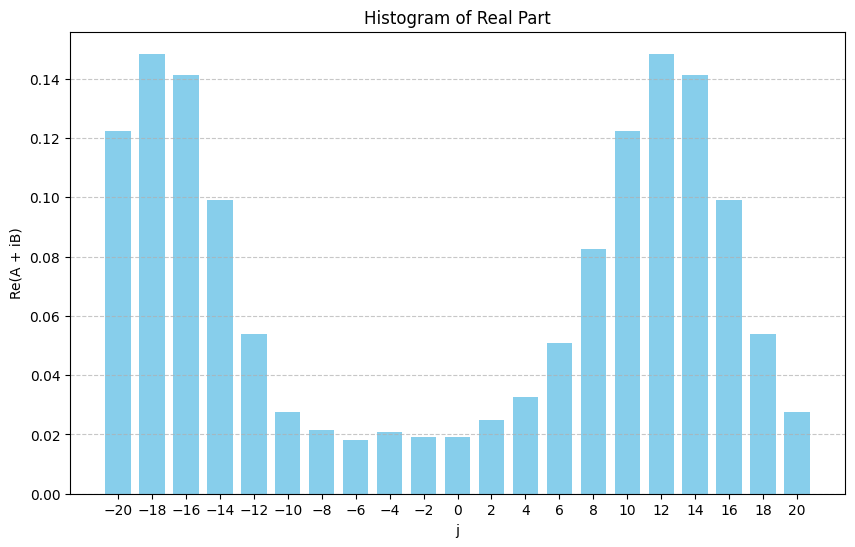

In [307]:
# 取 j 與實部
j_values = df_ft["j"].values
ft_real = np.real(df_ft["FT"].values)

# 依 j 排序
sorted_indices = np.argsort(j_values)
j_sorted = j_values[sorted_indices].astype(int)   # <-- 轉成整數
ft_sorted = ft_real[sorted_indices]

# 畫柱狀圖
plt.figure(figsize=(10,6))
plt.bar(j_sorted, ft_sorted, width=1.5, color='skyblue')
plt.xlabel("j")
plt.ylabel("Re(A + iB)")
plt.title("Histogram of Real Part")
plt.xticks(j_sorted)  # 每個 j 都顯示
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# put classic and quantum together

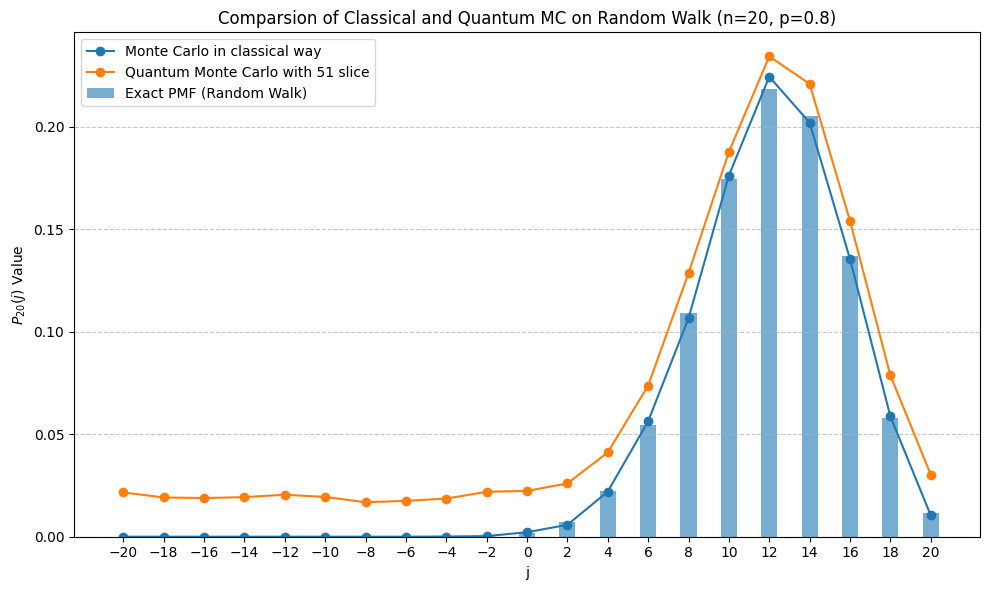

In [300]:

# -------------------- USER SETTINGS --------------------
p = 0.8        # Probability of moving right (+1) each step
n = 20         # Number of steps
RUN_SIM = True # Whether to run Monte Carlo verification
trials = 10000 # Number of Monte Carlo trials
# -------------------------------------------------------

def random_walk_pmf(n: int, p: float):
    """Exact distribution of 1D biased random walk (start at 0) after n steps."""
    if not (0 <= p <= 1):
        raise ValueError("p must be in [0, 1].")
    if n < 0 or int(n) != n:
        raise ValueError("n must be a non-negative integer.")

    js = np.arange(-n, n+1, 2)    # only positions with same parity as n
    k_right = (n + js) // 2       # number of +1 steps

    lgamma = math.lgamma
    if p == 0.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js == -n] = 1.0
        return js, pmf, k_right
    if p == 1.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js ==  n] = 1.0
        return js, pmf, k_right

    logC = np.array([lgamma(n+1) - lgamma(k+1) - lgamma(n-k+1) for k in k_right], dtype=float)
    logpmf = logC + k_right*np.log(p) + (n-k_right)*np.log(1-p)
    pmf = np.exp(logpmf)
    pmf = pmf / pmf.sum()  # normalize
    return js, pmf, k_right

def random_walk_monte_carlo(n: int, p: float, trials: int = 10000):
    """Monte Carlo empirical distribution for comparison."""
    steps = np.where(np.random.rand(trials, n) < p, 1, -1)
    positions = steps.sum(axis=1)
    counts = Counter(positions.tolist())
    js = np.arange(-n, n+1, 2)
    freq = np.array([counts.get(j, 0) for j in js], dtype=float) / trials
    return js, freq

# ==== 第一段: Random Walk 分佈 ====
js, pmf, _ = random_walk_pmf(n, p)

# ==== 第二段: df_ft histogram ====
# 假設 df_ft 已經存在且有 'j' 與 'FT' 欄位
j_values = df_ft["j"].values
ft_real = np.real(df_ft["FT"].values)

# 排序
sorted_indices = np.argsort(j_values)
j_sorted = j_values[sorted_indices].astype(int)
ft_sorted = ft_real[sorted_indices]

# ==== 疊圖 ====
plt.figure(figsize=(10,6))

# 第一段 Exact PMF
plt.bar(js, pmf, width=0.8, alpha=0.6, label="Exact PMF (Random Walk)")

# 如果要 Monte Carlo
if RUN_SIM:
    js_sim, freq = random_walk_monte_carlo(n, p, trials=trials)
    plt.plot(js_sim, freq, marker="o", linestyle="-", label=f"Monte Carlo in classical way")

# 第二段 histogram 疊上去
plt.plot(df_ft["j"], df_ft["FT"], marker='o', linestyle='-', label=f"Quantum Monte Carlo with 51 slice")

plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparsion of Classical and Quantum MC on Random Walk (n={n}, p={p})")
plt.xticks(sorted(set(j_sorted) | set(js)))  # 合併兩邊的 j 顯示
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# cut more slice

## put codes together

In [301]:
def random_walk_pmf(n: int, p: float):
    """Exact distribution of 1D biased random walk (start at 0) after n steps."""
    if not (0 <= p <= 1):
        raise ValueError("p must be in [0, 1].")
    if n < 0 or int(n) != n:
        raise ValueError("n must be a non-negative integer.")

    js = np.arange(-n, n+1, 2)    # only positions with same parity as n
    k_right = (n + js) // 2       # number of +1 steps

    lgamma = math.lgamma
    if p == 0.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js == -n] = 1.0
        return js, pmf, k_right
    if p == 1.0:
        pmf = np.zeros_like(js, dtype=float)
        pmf[js ==  n] = 1.0
        return js, pmf, k_right

    logC = np.array([lgamma(n+1) - lgamma(k+1) - lgamma(n-k+1) for k in k_right], dtype=float)
    logpmf = logC + k_right*np.log(p) + (n-k_right)*np.log(1-p)
    pmf = np.exp(logpmf)
    pmf = pmf / pmf.sum()  # normalize
    return js, pmf, k_right


def random_walk_monte_carlo(n: int, p: float, trials: int = 10000):
    """Monte Carlo empirical distribution for comparison."""
    steps = np.where(np.random.rand(trials, n) < p, 1, -1)
    positions = steps.sum(axis=1)
    counts = Counter(positions.tolist())
    js = np.arange(-n, n+1, 2)
    freq = np.array([counts.get(j, 0) for j in js], dtype=float) / trials
    return js, freq

0.9272952180016123


c:\Users\ACER\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ACER\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


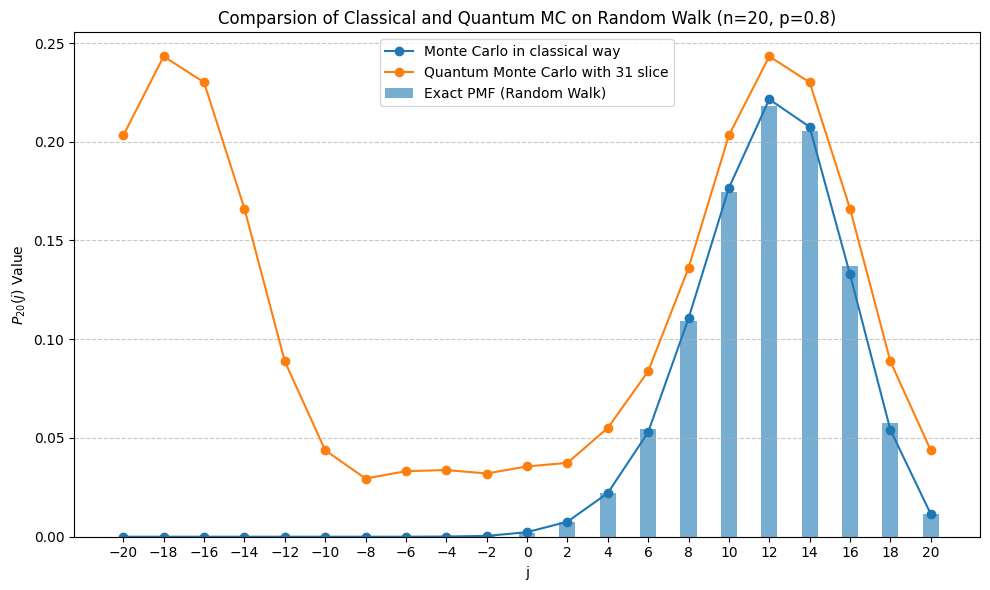

In [312]:
# phi
P = 0.8
phi = 2 * np.arccos(np.sqrt(P))
print(phi)

# settings
## slice
cut_slice = 31
## theta vals
theta_values = np.linspace(-np.pi, np.pi, cut_slice)
## step
step = 20

# A
results_list_A = []
for theta in theta_values:
    qr = QuantumRegister(step + 1, name='A')
    cr = ClassicalRegister(1, name='c_A')
    qc_A = QuantumCircuit(qr, cr)
    qc_A.ry(phi, range(step), r"$R_y(\phi)$")
    for ctrl_qubit in range(step):
        qc_A.x(ctrl_qubit)
        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_A.append(c_pos_gate, [ctrl_qubit, step])
        qc_A.x(ctrl_qubit)
        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_A.append(c_neg_gate, [ctrl_qubit, step])
        qc_A.barrier()
    qc_A.measure(step, 0)
    sampler = StatevectorSampler()
    result = sampler.run([(qc_A, None, 10000)]).result()
    data_pub = result[0].data
    counts = data_pub.c_A.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}
    one_value = frequencies.get('1', 0)
    results_list_A.append({
        "theta": theta,
        "freq_1": one_value
    })
df_A_v = pd.DataFrame(results_list_A)

# B
results_list_B = []
for theta in theta_values:
    qr = QuantumRegister(step + 1, name='B')
    cr = ClassicalRegister(1, name='c_B')
    qc_B = QuantumCircuit(qr, cr)
    qc_B.ry(phi, range(step), r"$R_y(\phi)$")
    qc_B.ry(-np.pi/2, step)
    for ctrl_qubit in range(step):
        qc_B.x(ctrl_qubit)
        c_pos_gate = control_pos_ry_gate(theta).control(1)
        qc_B.append(c_pos_gate, [ctrl_qubit, step])
        qc_B.x(ctrl_qubit)
        c_neg_gate = control_neg_ry_gate(theta).control(1)
        qc_B.append(c_neg_gate, [ctrl_qubit, step])
        qc_B.barrier()
    qc_B.measure(step, 0)
    sampler = StatevectorSampler()
    result = sampler.run([(qc_B, None, 10000)]).result()
    data_pub = result[0].data
    counts = data_pub.c_B.get_counts()
    total_shots = sum(counts.values())
    frequencies = {k: v / total_shots for k, v in counts.items()}
    one_value = frequencies.get('1', 0)
    results_list_B.append({
        "theta": theta,
        "freq_1": one_value
    })
df_B_v = pd.DataFrame(results_list_B)

# adjust df
## df A
adj_df_A_v = df_A_v.copy()
adj_df_A_v["adj_freq"] = 1 - 2 * adj_df_A_v["freq_1"]
adj_df_A_v = adj_df_A_v.drop(columns=["freq_1"])
## df B
adj_df_B_v = df_B_v.copy()
adj_df_B_v["adj_freq"] = 1 - 2 * adj_df_B_v["freq_1"]
adj_df_B_v = adj_df_B_v.drop(columns=["freq_1"])
## combine adj df
df_A_sorted = adj_df_A_v.sort_values(by="theta").reset_index(drop=True)
df_B_sorted = adj_df_B_v.sort_values(by="theta").reset_index(drop=True)
complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]
df_complex = pd.DataFrame({
    "theta": df_A_sorted["theta"],
    "A_plus_iB": complex_values
})

# caculate p_nj
j_values = np.arange(-step, step+1, 2)
df_p_nj = pd.DataFrame(columns=["j", "j_v"])
for j in j_values:
    ft_j = np.sum(df_complex["A_plus_iB"] * np.exp(-1j * df_complex["theta"] * j)) / len(theta_values)
    df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "j_v": [ft_j]})], ignore_index=True)

# plot
## classical & real
p = 0.8
n = 20
trials = 10000
js, pmf, _ = random_walk_pmf(n, p)
j_values = df_ft["j"].values
ft_real = np.real(df_ft["FT"].values)
sorted_indices = np.argsort(j_values)
j_sorted = j_values[sorted_indices].astype(int)
ft_sorted = ft_real[sorted_indices]
plt.figure(figsize=(10,6))
plt.bar(js, pmf, width=0.8, alpha=0.6, label="Exact PMF (Random Walk)")
js_sim, freq = random_walk_monte_carlo(n, p, trials=trials)
plt.plot(js_sim, freq, marker="o", linestyle="-", label=f"Monte Carlo in classical way")
plt.plot(df_p_nj["j"], df_p_nj["j_v"], marker='o', linestyle='-', label=f"Quantum Monte Carlo with {cut_slice} slice")
plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparsion of Classical and Quantum MC on Random Walk (n={n}, p={p})")
plt.xticks(sorted(set(j_sorted) | set(js)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()




## for loop

### p = 0.8

0.9272952180016123
Running cut_slice = 51
cut_slice=51 完成，耗時 832.77 秒
Running cut_slice = 81
cut_slice=81 完成，耗時 781.57 秒
Running cut_slice = 111
cut_slice=111 完成，耗時 1004.05 秒
Running cut_slice = 141
cut_slice=141 完成，耗時 1221.46 秒
Running cut_slice = 171
cut_slice=171 完成，耗時 1485.73 秒


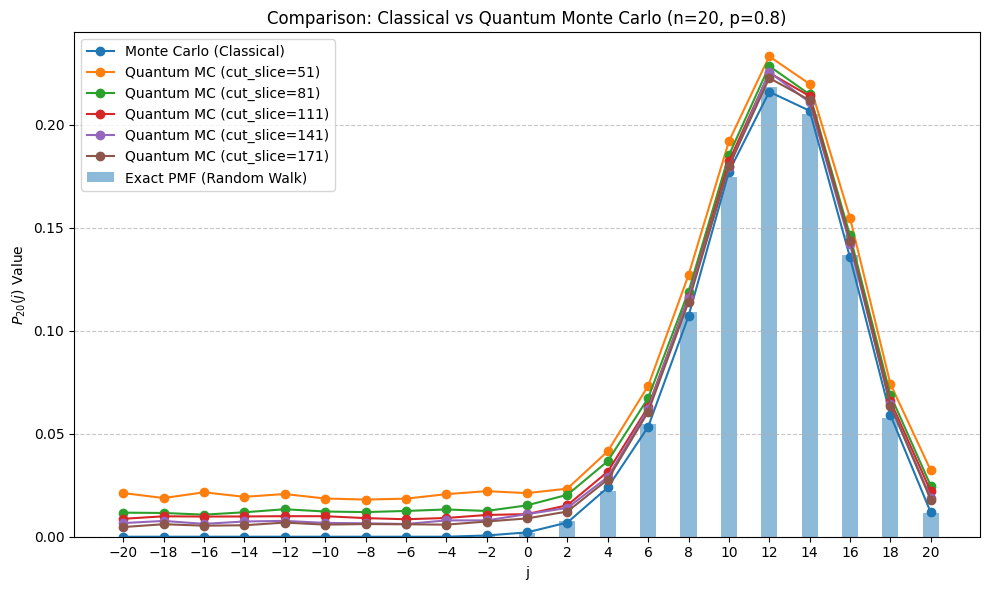

In [318]:
# phi
P = 0.8
phi = 2 * np.arccos(np.sqrt(P))
print(phi)

# step
step = 20

# 存所有結果
all_results = []

# 迴圈跑不同 cut_slice
for cut_slice in range(51, 172, 30):
    start_time = time.time()  # 開始計時
    print(f"Running cut_slice = {cut_slice}")
    theta_values = np.linspace(-np.pi, np.pi, cut_slice)

    # A
    results_list_A = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='A')
        cr = ClassicalRegister(1, name='c_A')
        qc_A = QuantumCircuit(qr, cr)
        qc_A.ry(phi, range(step), r"$R_y(\phi)$")
        for ctrl_qubit in range(step):
            qc_A.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_A.append(c_pos_gate, [ctrl_qubit, step])
            qc_A.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_A.append(c_neg_gate, [ctrl_qubit, step])
            qc_A.barrier()
        qc_A.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_A, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_A.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_A.append({"theta": theta, "freq_1": one_value})
    df_A_v = pd.DataFrame(results_list_A)

    # B
    results_list_B = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='B')
        cr = ClassicalRegister(1, name='c_B')
        qc_B = QuantumCircuit(qr, cr)
        qc_B.ry(phi, range(step), r"$R_y(\phi)$")
        qc_B.ry(-np.pi/2, step)
        for ctrl_qubit in range(step):
            qc_B.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_B.append(c_pos_gate, [ctrl_qubit, step])
            qc_B.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_B.append(c_neg_gate, [ctrl_qubit, step])
            qc_B.barrier()
        qc_B.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_B, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_B.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_B.append({"theta": theta, "freq_1": one_value})
    df_B_v = pd.DataFrame(results_list_B)

    # 調整數值
    adj_df_A_v = df_A_v.copy()
    adj_df_A_v["adj_freq"] = 1 - 2 * adj_df_A_v["freq_1"]
    adj_df_B_v = df_B_v.copy()
    adj_df_B_v["adj_freq"] = 1 - 2 * adj_df_B_v["freq_1"]
    df_A_sorted = adj_df_A_v.sort_values(by="theta").reset_index(drop=True)
    df_B_sorted = adj_df_B_v.sort_values(by="theta").reset_index(drop=True)
    complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]

    # Fourier Transform
    j_values = np.arange(-step, step+1, 2)
    df_p_nj = pd.DataFrame(columns=["j", "FT"])
    for j in j_values:
        ft_j = np.sum(complex_values * np.exp(-1j * df_A_sorted["theta"] * j)) / len(theta_values)
        df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)

    df_p_nj["cut_slice"] = cut_slice
    all_results.append(df_p_nj)

    # 計算並輸出時間
    elapsed_time = time.time() - start_time
    print(f"cut_slice={cut_slice} 完成，耗時 {elapsed_time:.2f} 秒")

# 合併所有結果
final_total_df = pd.concat(all_results, ignore_index=True)

# 繪圖
p = 0.8
n = 20
trials = 10000
js_exact, pmf_exact, _ = random_walk_pmf(n, p)
js_sim, freq_sim = random_walk_monte_carlo(n, p, trials=trials)
plt.figure(figsize=(10, 6))
plt.bar(js_exact, pmf_exact, width=0.8, alpha=0.5, label="Exact PMF (Random Walk)")
plt.plot(js_sim, freq_sim, marker="o", linestyle="-", label="Monte Carlo (Classical)")
for cut_slice in final_total_df["cut_slice"].unique():
    sub_df = final_total_df[final_total_df["cut_slice"] == cut_slice]
    plt.plot(sub_df["j"], sub_df["FT"], marker='o', linestyle='-', label=f"Quantum MC (cut_slice={cut_slice})")
plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparison: Classical vs Quantum Monte Carlo (n={n}, p={p})")
plt.xticks(sorted(set(js_exact) | set(js_sim) | set(final_total_df["j"])))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



1.5707963267948966
Running cut_slice = 51
cut_slice=51 完成，耗時 419.55 秒
Running cut_slice = 81
cut_slice=81 完成，耗時 680.69 秒
Running cut_slice = 111
cut_slice=111 完成，耗時 864.06 秒
Running cut_slice = 141
cut_slice=141 完成，耗時 1135.84 秒
Running cut_slice = 171
cut_slice=171 完成，耗時 1445.77 秒


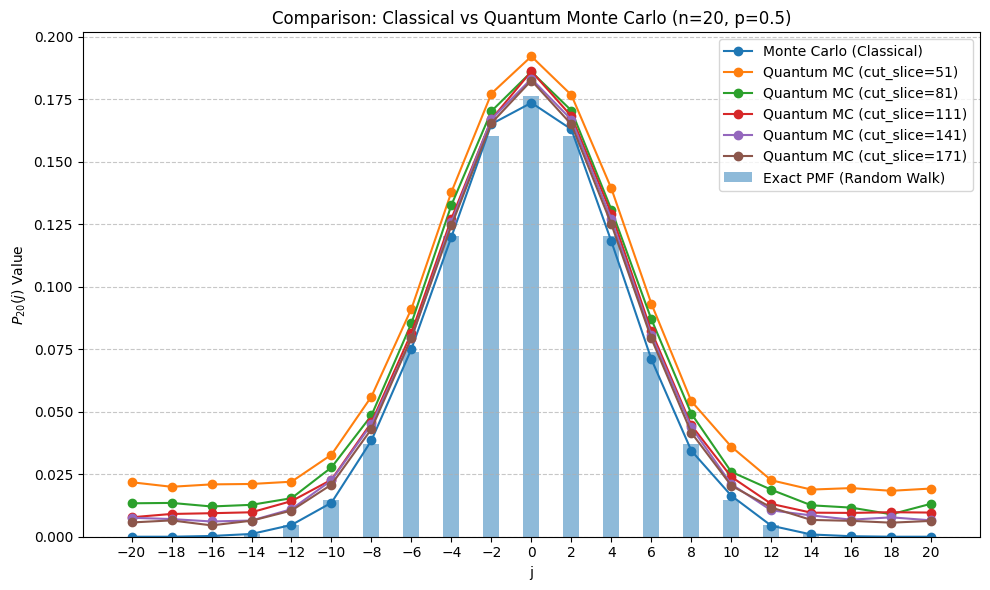

In [319]:
# phi
P = 0.5
phi = 2 * np.arccos(np.sqrt(P))
print(phi)

# step
step = 20

# 存所有結果
all_results = []

# 迴圈跑不同 cut_slice
for cut_slice in range(51, 172, 30):
    start_time = time.time()  # 開始計時

    print(f"Running cut_slice = {cut_slice}")
    theta_values = np.linspace(-np.pi, np.pi, cut_slice)

    # A
    results_list_A = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='A')
        cr = ClassicalRegister(1, name='c_A')
        qc_A = QuantumCircuit(qr, cr)
        qc_A.ry(phi, range(step), r"$R_y(\phi)$")
        for ctrl_qubit in range(step):
            qc_A.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_A.append(c_pos_gate, [ctrl_qubit, step])
            qc_A.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_A.append(c_neg_gate, [ctrl_qubit, step])
            qc_A.barrier()
        qc_A.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_A, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_A.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_A.append({"theta": theta, "freq_1": one_value})
    df_A_v = pd.DataFrame(results_list_A)

    # B
    results_list_B = []
    for theta in theta_values:
        qr = QuantumRegister(step + 1, name='B')
        cr = ClassicalRegister(1, name='c_B')
        qc_B = QuantumCircuit(qr, cr)
        qc_B.ry(phi, range(step), r"$R_y(\phi)$")
        qc_B.ry(-np.pi/2, step)
        for ctrl_qubit in range(step):
            qc_B.x(ctrl_qubit)
            c_pos_gate = control_pos_ry_gate(theta).control(1)
            qc_B.append(c_pos_gate, [ctrl_qubit, step])
            qc_B.x(ctrl_qubit)
            c_neg_gate = control_neg_ry_gate(theta).control(1)
            qc_B.append(c_neg_gate, [ctrl_qubit, step])
            qc_B.barrier()
        qc_B.measure(step, 0)
        sampler = StatevectorSampler()
        result = sampler.run([(qc_B, None, 10000)]).result()
        data_pub = result[0].data
        counts = data_pub.c_B.get_counts()
        total_shots = sum(counts.values())
        frequencies = {k: v / total_shots for k, v in counts.items()}
        one_value = frequencies.get('1', 0)
        results_list_B.append({"theta": theta, "freq_1": one_value})
    df_B_v = pd.DataFrame(results_list_B)

    # 調整數值
    adj_df_A_v = df_A_v.copy()
    adj_df_A_v["adj_freq"] = 1 - 2 * adj_df_A_v["freq_1"]
    adj_df_B_v = df_B_v.copy()
    adj_df_B_v["adj_freq"] = 1 - 2 * adj_df_B_v["freq_1"]
    df_A_sorted = adj_df_A_v.sort_values(by="theta").reset_index(drop=True)
    df_B_sorted = adj_df_B_v.sort_values(by="theta").reset_index(drop=True)
    complex_values = df_A_sorted["adj_freq"] + 1j * df_B_sorted["adj_freq"]

    # Fourier Transform
    j_values = np.arange(-step, step+1, 2)
    df_p_nj = pd.DataFrame(columns=["j", "FT"])
    for j in j_values:
        ft_j = np.sum(complex_values * np.exp(-1j * df_A_sorted["theta"] * j)) / len(theta_values)
        df_p_nj = pd.concat([df_p_nj, pd.DataFrame({"j": [j], "FT": [np.real(ft_j)]})], ignore_index=True)

    df_p_nj["cut_slice"] = cut_slice
    all_results.append(df_p_nj)

    # 計算並輸出時間
    elapsed_time = time.time() - start_time
    print(f"cut_slice={cut_slice} 完成，耗時 {elapsed_time:.2f} 秒")

# 合併所有結果
final_total_df = pd.concat(all_results, ignore_index=True)

# 繪圖
p = 0.5
n = 20
trials = 10000
js_exact, pmf_exact, _ = random_walk_pmf(n, p)
js_sim, freq_sim = random_walk_monte_carlo(n, p, trials=trials)
plt.figure(figsize=(10, 6))
plt.bar(js_exact, pmf_exact, width=0.8, alpha=0.5, label="Exact PMF (Random Walk)")
plt.plot(js_sim, freq_sim, marker="o", linestyle="-", label="Monte Carlo (Classical)")
for cut_slice in final_total_df["cut_slice"].unique():
    sub_df = final_total_df[final_total_df["cut_slice"] == cut_slice]
    plt.plot(sub_df["j"], sub_df["FT"], marker='o', linestyle='-', label=f"Quantum MC (cut_slice={cut_slice})")
plt.xlabel("j")
plt.ylabel(r"$P_{20}(j)$ Value")
plt.title(f"Comparison: Classical vs Quantum Monte Carlo (n={n}, p={p})")
plt.xticks(sorted(set(js_exact) | set(js_sim) | set(final_total_df["j"])))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


$P_n(j) = \frac{1}{2 \pi} \int^{\pi}_{-\pi} (pe^{i\theta}+qe^{-i\theta})^{n} e^{-i \theta j} d \theta = \frac{1}{2 \pi} \underbrace{\sum^{\pi}_{\theta = -\pi}}_{M_i \text{ number of devision}} (pe^{i\theta}+qe^{-i\theta})^{\overbrace{n}^{\text{number of steps}}} e^{-i \theta j} \frac{2 \pi}{M}$